# **Recommeder System Using Amazon Reviews**

> <center><img src="https://cdn.vox-cdn.com/thumbor/yUpkdU-kEcTqiO0gntohs74rXYE=/1400x788/filters:format(jpeg)/cdn.vox-cdn.com/uploads/chorus_asset/file/19718016/Amazon_Reviews_Final.jpg" width="1000px"></center>

<h1 style='color:white;background-color:black' > Table of Contents </h1>

* [Introduction](#introduction)
* [Data Acquisition](#data_acquisition)
* [EDA](#eda)
* [Type of Recommender System](#recommender)
    * [Popular-Based](#popular)
    * [Content-Based](#content)
    * [Collaborative Filtering](#colla)
    * [Hybrid](#hybrid)

<a id="introduction"></a>
## 1. Introduction

<div align='left'><font size="3" color="#000000"> Online E-commerce websites like Amazon, Filpkart uses different recommendation models to provide different suggestions to different users. Amazon currently uses item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real time. This type of filtering matches each of the user's purchased and rated items to similar items, then combines those similar items into a recommendation list for the user.
</font></div>

* **Goal:**
<div align='left'><font size="3" color="#000000"> In this project we are going to build recommendation model for the electronics products of Amazon.
</font></div>


* **Attribute Information:**
<div align='left'><font size="3" color="#000000"> 
<ul>
  <li>userId : Every user identified with a unique id (First Column)</li>
  <li>productId : Every product identified with a unique id(Second Column)</li>
  <li>Rating : Rating of the corresponding product by the corresponding user(Third Column)</li>
  <li>timestamp : Time of the rating ( Fourth Column)</li>
</ul>
</font></div>


<a id="data_acquisition"></a>
## 2. Data Acquisition

### Import Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

# Split
from sklearn.model_selection import train_test_split

from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate



ModuleNotFoundError: No module named 'surprise'

### Load Dataset

In [3]:
df = pd.read_csv(r"C:\Users\SUPER\Downloads\ratings_Electronics.csv",
                             names=['userId', 'productId','rating','timestamp'])

<a id="eda"></a>
## 3. EDA

In [3]:
df.head()

,userId,productId,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [4]:
print("Total Reviews:",df.shape[0])
print("Total Columns:",df.shape[1])

Total Reviews: 7824482
Total Columns: 4


In [5]:
# Taking subset of the dataset
df = df.iloc[:5000,0:]

In [6]:
print("Total Reviews:",df.shape[0])
print("Total Columns:",df.shape[1])

Total Reviews: 5000
Total Columns: 4


In [7]:
print("Total number of ratings :",df.rating.nunique())
print("Total number of users   :", df.userId.nunique())
print("Total number of products  :", df.productId.nunique())

Total number of ratings : 5
Total number of users   : 4929
Total number of products  : 299


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userId     5000 non-null   object 
 1   productId  5000 non-null   object 
 2   rating     5000 non-null   float64
 3   timestamp  5000 non-null   int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 156.4+ KB


In [9]:
# Check missing value
df.isnull().sum()

userId       0
productId    0
rating       0
timestamp    0
dtype: int64

In [10]:
# Check Duplicate data
df[df.duplicated()].any()

userId       False
productId    False
rating       False
timestamp    False
dtype: bool

In [11]:
# rating describe summary 
df.describe()['rating']

count    5000.000000
mean        3.986600
std         1.411814
min         1.000000
25%         3.000000
50%         5.000000
75%         5.000000
max         5.000000
Name: rating, dtype: float64

In [12]:
print("Unique value of Rating:",df.rating.unique())

Unique value of Rating: [5. 1. 3. 2. 4.]


In [13]:
# Find the minimum and maximum ratings
print('Minimum rating is: %d' %(df.rating.min()))
print('Maximum rating is: %d' %(df.rating.max()))

Minimum rating is: 1
Maximum rating is: 5


### 3.1 Data Visualization

In [14]:
# Average rating of products
ratings = pd.DataFrame(df.groupby('productId')['rating'].mean())
ratings['ratings_count'] = pd.DataFrame(df.groupby('productId')['rating'].count())
ratings['ratings_average'] = pd.DataFrame(df.groupby('productId')['rating'].mean())
ratings.head(10)

,rating,ratings_count,ratings_average
productId,,,
0132793040,5.000000,1,5.000000
0321732944,5.000000,1,5.000000
0439886341,1.666667,3,1.666667
0511189877,4.500000,6,4.500000
0528881469,2.851852,27,2.851852
0558835155,3.000000,1,3.000000
059400232X,5.000000,3,5.000000
0594012015,2.000000,8,2.000000
0594017343,1.000000,1,1.000000


<AxesSubplot:>

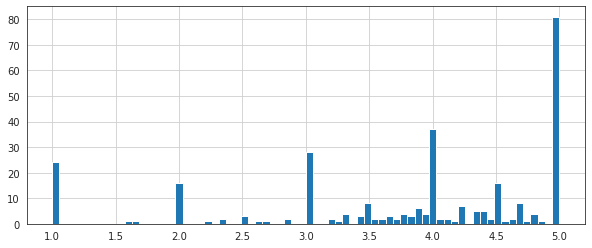

In [15]:
plt.figure(figsize=(10,4))
ratings['rating'].hist(bins=70)

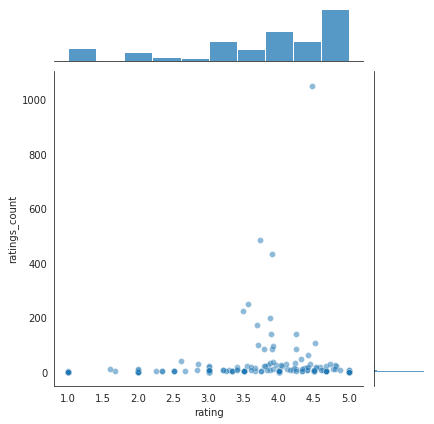

In [16]:
sns.jointplot(x='rating',y='ratings_count',data=ratings,alpha=0.5)

<AxesSubplot:xlabel='productId'>

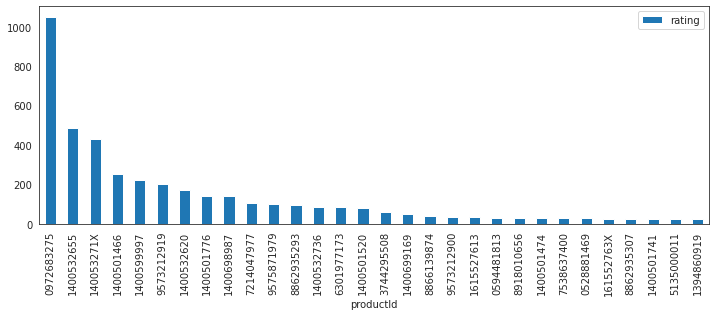

In [17]:
# Most top 30 products
popular_products = pd.DataFrame(df.groupby('productId')['rating'].count())
most_popular = popular_products.sort_values('rating', ascending=False)
most_popular.head(30).plot(kind = "bar",figsize=(12, 4))

<a id="recommender"></a>
## 4. Type of Recommender System

### Methods Used
<div align='left'><font size="3" color="#000000"> Four types of recommender systems:
</font></div>

<div align='left'><font size="3" color="#000000"> 
<ol>
  <li>Popular-Based</li>
  <li>Content-Based</li>
  <li>Collaborative Filtering</li>
  <li>Hybrid</li>
</ol>
</font></div>

> <center><img src="https://miro.medium.com/max/700/1*AaE5pUCOkMS6Dv6j96trsA.png" width="500px"></center>

<a id="popular"></a>
### 1. Popular-Based

<div align='left'><font size="3" color="#000000"> This is the baseline performance and the most intuitive recommendation that we can find anywhere. Examples are the IMDB top-rated movies, Top 10 in your country today in Netflix, etc. These recommendations can be found when you are a new joiner and the provider doesn't have enough information about you. So it would be a safe bet to recommend to you what others like.
</font></div>

<div align='left'><font size="3" color="#000000">❗ Limitation: All users get the same recommendation set. It's not personalized.
</font></div>

<div align='left'><font size="3" color="#000000">Example illustration for movie recommendation below:
</font></div>

> <center><img src="https://miro.medium.com/max/646/1*7v-Ha1BOzh2r2y_96WceIg.png" width="500px"></center>


#### 1.1 Develop Recommendation System using Popular-Based method

<div align='left'><font size="3" color="#000000"> Weighted rating systems used to score the rating of each movie. Here is the formula of the weighted rating score.
</font></div>

<div align='center'><font size="4" color="#000000"> WR = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C
</font></div>

<div align='left'><font size="3" color="#000000"> 
<ul>
  <li>R is the average rating for the item.</li>
  <li>v is the number of votes for the item.</li>
  <li>m is the minimum votes required to be listed in the popular items(defined by > percentile 80 of total votes)</li>
  <li>C is the average rating across the whole dataset.</li>
</ul>
</font></div>

In [18]:
vote_counts = ratings[ratings['ratings_count'].notnull()]['ratings_count'].astype('int')
vote_averages = ratings[ratings['ratings_average'].notnull()]['ratings_average'].astype('int')
C = vote_averages.mean()
print("Average rating of product across the whole dataset is",C)

Average rating of product across the whole dataset is 3.5953177257525084


In [19]:
m = vote_counts.quantile(0.95)
print("Minimum votes required to be listed in the chart is",m)

Minimum votes required to be listed in the chart is 62.19999999999925


In [20]:
ratings.head()

,rating,ratings_count,ratings_average
productId,,,
0132793040,5.000000,1,5.000000
0321732944,5.000000,1,5.000000
0439886341,1.666667,3,1.666667
0511189877,4.500000,6,4.500000
0528881469,2.851852,27,2.851852


In [21]:
qualified = ratings[(ratings['ratings_count'] >= m) & (ratings['ratings_count'].notnull()) & (ratings['ratings_average'].notnull())][['ratings_count', 'ratings_average']]

In [22]:
qualified['ratings_count'] = qualified['ratings_count'].astype('int')
qualified['ratings_average'] = qualified['ratings_average'].astype('int')
qualified.head().sort_values(by='ratings_count', ascending=False)

,ratings_count,ratings_average
productId,,
0972683275,1051,4
1400501466,250,3
1400532620,171,3
1400501776,139,3
1400501520,82,4


In [23]:
qualified.shape

(15, 2)

In [24]:
def weighted_rating(x):
    v = x['ratings_count']
    R = x['ratings_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [25]:
qualified['wr'] = qualified.apply(weighted_rating, axis=1)

In [26]:
qualified = qualified.sort_values('wr', ascending=False).head(20)

#### 1.2 Top 10 Products for recommendation using Popular-based method

In [27]:
qualified.head(10)

,ratings_count,ratings_average,wr
productId,,,
0972683275,1051,4,3.977388
1400698987,138,4,3.874270
7214047977,107,4,3.851234
1400501520,82,4,3.825442
6301977173,83,3,3.255019
1400532736,84,3,3.253275
8862935293,95,3,3.235552
9575871979,98,3,3.231141
1400501776,139,3,3.184040


Text(0, 0.5, 'Count')

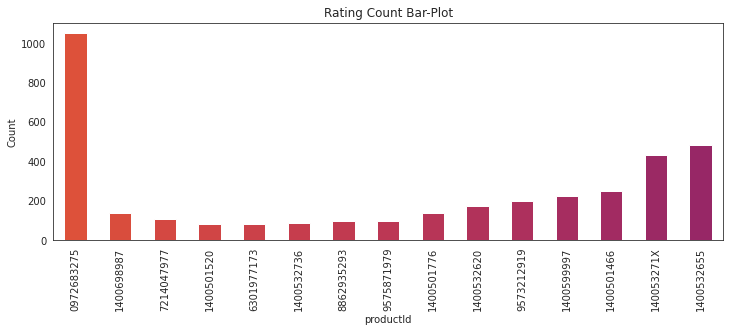

In [28]:
# Add color
from matplotlib import cm
color = cm.inferno_r(np.linspace(.4, .8, 30))

rating_plot_count = qualified['ratings_count'].plot.bar(figsize=(12, 4),color=color)
rating_plot_count.set_title("Rating Count Bar-Plot")
rating_plot_count.set_xlabel("productId")
rating_plot_count.set_ylabel("Count")

Text(0, 0.5, 'rating')

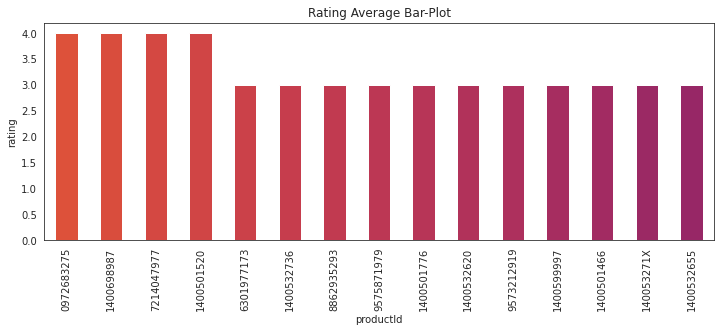

In [29]:
rating_plot_avg = qualified['ratings_average'].plot.bar(figsize=(12, 4),color=color)
rating_plot_avg.set_title("Rating Average Bar-Plot")
rating_plot_avg.set_xlabel("productId")
rating_plot_avg.set_ylabel("rating")

Text(0, 0.5, 'rating')

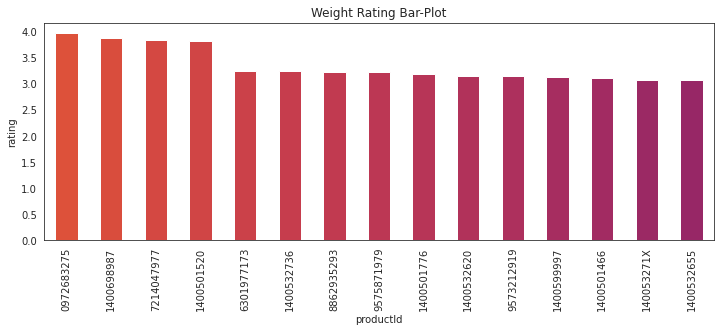

In [30]:
wr_plot = qualified['wr'].plot.bar(figsize=(12, 4),color=color)
wr_plot.set_title("Weight Rating Bar-Plot")
wr_plot.set_xlabel("productId")
wr_plot.set_ylabel("rating")

<a id="content"></a>
### 2. Content-Based

<div align='left'><font size="3" color="#000000"> This method will be similar to the popular-based or content-based recommendation. However, the difference is how to come up with a set of similar items. Here we use the user-item interaction matrix rather than the rating or genres like the methods mentioned above. In general, content-based focuses on the attributes of items and provides you with recommendations based on the similarities between them. We will find similarities between each type of product item and rank the similarity score from highest to lowest and select product sets based on the number of recommendations we want to offer.
</font></div>

<div align='left'><font size="3" color="#000000">❗ Limitation: The recommendation will be limited to what users liked, watched, interacted with before. It doesn't give users a chance to explore a new area they’ve never been to before. Also, all users who like item X will receive the same recommendation set.
</font></div>

<div align='left'><font size="3" color="#000000">Example illustration for movie recommendation below:
</font></div>

> <center><img src="https://miro.medium.com/max/647/1*NvmFrVY5BDI7Fjw6SO9Kbg.png" width="500px"></center>

<div align='left'><font size="3" color="#000000"> In this particular case, no product type is represented so we can't really implement this method due to the lack of information about the product type.
</font></div>

### 3. Collaborative Filtering

<div align='left'><font size="3" color="#000000"> In general, Collaborative filtering (CF) is more commonly used than content-based systems because it usually gives better results and is relatively easy to understand (from an overall implementation perspective). CF is based on the idea that the best recommendations come from people who have similar tastes. In other words, it uses historical item ratings of like-minded people to predict how someone would rate an item.
</font></div>

<div align='left'><font size="3" color="#000000"> Collaborative filtering recommends the set of items based on what is called the user-item interaction matrix. Here is how the user-item interaction matrix look likes.
</font></div>



> <center><img src="https://miro.medium.com/max/614/1*HzXfBUMiFl6gezFT9bx-Tw.png" width="500px"></center>

<div align='left'><font size="3" color="#000000">Collaborative filtering  can be divided into two:
</font></div>

<div align='left'><font size="3" color="#000000"> 
<ul>
  <li>Memory-Based Collaborative Filtering</li>
  <li>Model-Based Collaborative filtering</li>
</ul>
</font></div>

#### 1.1 Memory-Based Collaborative Filtering

<div align='left'><font size="3" color="#000000">Memory-Based Collaborative Filtering approaches can be divided into two main sections: 
</font></div>

<div align='left'><font size="3" color="#000000"> 
<ul>
  <li>User-item filtering</li>
  <li>Item-item filtering</li>
</ul>
</font></div>

<div align='left'><font size="3" color="#000000">A user-item filtering will take a particular user, find users that are similar to that user based on similarity of ratings, and recommend items that those similar users liked. 
</font></div>

<div align='left'><font size="3" color="#000000">In contrast, item-item filtering will take an item, find users who liked that item, and find other items that those users or similar users also liked. It takes items and outputs other items as recommendations. 
</font></div>

<div align='left'><font size="3" color="#000000"> 
<ul>
  <li>Item-Item Collaborative Filtering: “Users who liked this item also liked …”</li>
  <li>User-Item Collaborative Filtering: “Users who are similar to you also liked …”</li>
</ul>
</font></div>

#### 1.1.1 Collaberative filtering (User-Item recommedation)

<div align='left'><font size="3" color="#000000">In this method we will be using a well-known matrix factorization called Singular value decomposition (SVD). This technique will personalize our recommendation based on the similar group of users we derived from the above user-item interaction matrix. The below figure shows you how we came up with the set of recommendations for user#1. You can see that for each user, the set of recommendations will change based on the group of similar users, and the group of similar users will vary based on how user#1 interacts with each item.
</font></div>

> <center><img src="https://miro.medium.com/max/700/1*YGDIaNdODnlvhA7BrDoXVA.png" width="700px"></center>

In [31]:
reader = Reader()

In [32]:
df.head()

,userId,productId,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [33]:
data = Dataset.load_from_df(df[['userId', 'productId', 'rating']], reader)

In [34]:
# Use the famous SVD algorithm
svd = SVD()

# Run 5-fold cross-validation and then print results
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.4031  1.3140  1.3673  1.3382  1.3889  1.3623  0.0326  
MAE (testset)     1.1339  1.0806  1.0978  1.0878  1.1300  1.1060  0.0219  
Fit time          0.41    0.41    0.42    0.42    0.42    0.42    0.00    
Test time         0.01    0.01    0.01    0.01    0.01    0.01    0.00    


{'test_rmse': array([1.40307088, 1.31402659, 1.36734164, 1.33816868, 1.38888494]),
 'test_mae': array([1.13387536, 1.08057958, 1.09778344, 1.08783654, 1.12996641]),
 'fit_time': (0.40844202041625977,
  0.413013219833374,
  0.422243595123291,
  0.4189414978027344,
  0.41671276092529297),
 'test_time': (0.009966373443603516,
  0.00997018814086914,
  0.009195566177368164,
  0.009033679962158203,
  0.009418249130249023)}

<div align='left'><font size="3" color="#000000">From these results, the mean Root Mean Square Error is not good for our case, this happens due to several factors such as lack of training data because we only apply 5000 data. Now let's train our dataset and make some predictions.
</font></div>

In [35]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [36]:
df.head()

,userId,productId,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [37]:
df['userId'].value_counts()

A3LDPF5FMB782Z    5
A36V8NDDRZYRYO    3
A3E7PG9CHDBICA    3
AOY9SZTMNQWAW     3
A2FHM5FB0BXKGA    3
                 ..
A1W92X1R9QNM2C    1
A1KW4AGRCOIWI2    1
A1B6WHCBJSNO6J    1
A3BEVLI33Q0ZF4    1
A1TYKVIT4FTMRO    1
Name: userId, Length: 4929, dtype: int64

In [38]:
# Check specific userId review
df[df['userId'] == 'A3LDPF5FMB782Z']

,userId,productId,rating,timestamp
1310,A3LDPF5FMB782Z,1400501466,5.0,1336003200
1588,A3LDPF5FMB782Z,1400501520,5.0,1362873600
1696,A3LDPF5FMB782Z,1400501776,5.0,1334102400
2502,A3LDPF5FMB782Z,140053271X,4.0,1310515200
3235,A3LDPF5FMB782Z,1400698987,4.0,1392854400


In [39]:
# predict based on this data
svd.predict('A3LDPF5FMB782Z', '140053271X', 5.0)

Prediction(uid='A3LDPF5FMB782Z', iid='140053271X', r_ui=5.0, est=3.9088877933601527, details={'was_impossible': False})

<div align='left'><font size="3" color="#000000">From the prediction results, we have estimation that are quite close to the actual value.
</font></div>

<a id="hybrid"></a>
### 4. Hybrid

<div align='left'><font size="3" color="#000000">We see that each method has its strength. It would be best if we can combine all those strengths and provide a better recommendation. This idea leads us to another improvement of the recommendation, which is the hybrid method. For example, we can combine the content-based and item-based collaborative filtering recommendations together to leverage both domain features (genres and user-item interaction).
</font></div>

## 5. References

<div align='left'><font size="3" color="#000000"> 
<ul>
  <li>https://www.kaggle.com/rounakbanik/movie-recommender-systems</li>
  <li>https://towardsdatascience.com/a-complete-guide-to-recommender-system-tutorial-with-sklearn-surprise-keras-recommender-5e52e8ceace1</li>
</ul>
</font></div>